In [1]:
import pandas as pd 
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:

data = pd.read_csv('/content/dep_arr.csv')
# Dataset is now stored in a Pandas Dataframe

In [3]:
data

,DEP_DELAY_NEW,ARR_DELAY_NEW,Unnamed: 2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
660551,1955.0,1937.0,NaN
660552,2173.0,2188.0,NaN
660553,2246.0,2228.0,NaN
660554,2327.0,2308.0,NaN


In [4]:
data.drop(['Unnamed: 2'],axis=1,inplace=True)

In [5]:
data.dropna(inplace=True)

In [6]:
data

,DEP_DELAY_NEW,ARR_DELAY_NEW
8113,0.0,0.0
8114,0.0,0.0
8115,0.0,0.0
8116,0.0,0.0
8117,0.0,0.0
...,...,...
660551,1955.0,1937.0
660552,2173.0,2188.0
660553,2246.0,2228.0
660554,2327.0,2308.0


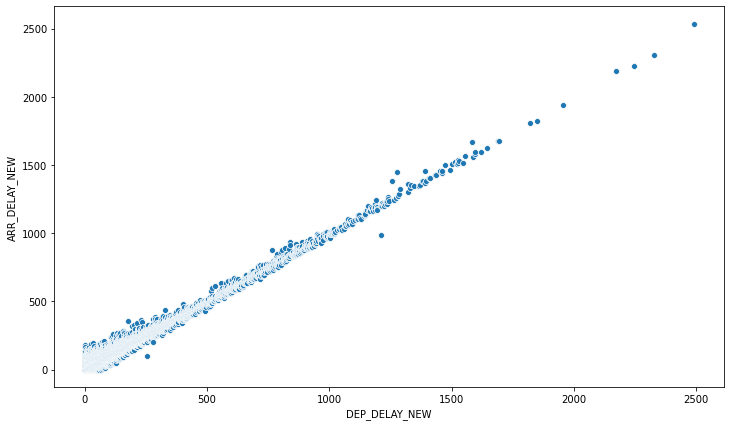

In [7]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=data,x='DEP_DELAY_NEW',y='ARR_DELAY_NEW',palette='winter')
plt.show()

# 1) Define the MDN

In [8]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import tensorflow.keras as K
from tensorflow_probability import distributions as tfd
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

In [9]:
class MDN(tf.keras.Model):

    def __init__(self, neurons=100, components = 2):
        super(MDN, self).__init__(name="MDN")
        self.neurons = neurons
        self.components = components
        
        self.h1 = Dense(neurons, activation="relu", name="h1")
        self.h2 = Dense(neurons, activation="relu", name="h2")
        
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, name="mus")
        self.sigmas = Dense(components, activation="nnelu", name="sigmas")
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x = self.h1(inputs)
        x = self.h2(x)
        
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v, mu_v, sigma_v])
    
class DNN(tf.keras.Model):
    def __init__(self, neurons=100):
        super(DNN, self).__init__(name="DNN")
        self.neurons = neurons
        
        self.h1 = Dense(neurons, activation="relu", name="h1")
        self.h2 = Dense(neurons, activation="relu", name="h2")
        self.out = Dense(1, activation="linear", name="out")
        
    def call(self, inputs):
        x = self.h1(inputs)
        x = self.h2(x)
        return self.out(x)

In [10]:
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1)*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha, mu, sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    
    log_likelihood = gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y
    
    return -tf.reduce_mean(log_likelihood, axis=-1)

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

In [19]:
no_parameters = 3
components = 1
neurons = 200

opt = tf.optimizers.Adam()#tf.train.AdamOptimizer(1e-3)

mon = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

In [20]:
mdn = MDN(neurons=neurons, components=components)
mdn.compile(loss=gnll_loss, optimizer=opt)

In [21]:
x=data["DEP_DELAY_NEW"]
y=data['ARR_DELAY_NEW']
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=42)

In [22]:
tf.keras.backend.set_floatx('float64')

In [23]:

mdn.fit(x=x_train, y=y_train,epochs=200, validation_data=(x_test, y_test), callbacks=[mon], batch_size=128, verbose=0)
y_pred= mdn.predict(x_test)
alpha_pred, mu_pred, sigma_pred = slice_parameter_vectors(y_pred)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [24]:
y_pred

array([[ 1.        ,  1.20438636,  5.47140932],
       [ 1.        ,  1.20438636,  5.47140932],
       [ 1.        ,  1.20438636,  5.47140932],
       ...,
       [ 1.        , 33.59436451, 15.05301189],
       [ 1.        ,  1.20438636,  5.47140932],
       [ 1.        ,  1.20438636,  5.47140932]])